In [1]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICES = 1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import sys

import numpy as np
import os
import blosc

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import os
import blosc
import simplejson

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.contrib.layers import xavier_initializer_conv2d
from scipy.interpolate import spline
from collections import defaultdict

sys.path.append("..")
    
from dataset import DatasetIndex, Dataset
from dataset import Batch, action, model, inbatch_parallel
from wide_resnet import MnistBatch
from wide_resnet import draw_stats

In [3]:
src = 'C:/Users/Dari/Documents/az_training/task_03'

with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    full_imgs = blosc.unpack_array(file.read())
    
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    full_labs = blosc.unpack_array(file.read())
    
src = (np.reshape(full_imgs, (65000, 28, 28)), full_labs)

# LEN_MNIST = 65000
# indy = DatasetIndex(np.arange(LEN_MNIST))

# mnistset = Dataset(indy, batch_class=MnistBatch)
# mnistset.cv_split([0.9, 0.1])

ix = DatasetIndex(range(58500))
train_dataset = Dataset(ix, MnistBatch)


In [4]:
test_ix = DatasetIndex(range(65000-58500))
test_dataset = Dataset(test_ix, MnistBatch)

In [5]:
n_iterations = 400

In [6]:
widening_factors = list(range(1, 10))

In [7]:
widening_factors = [0.5, 4]

In [8]:
convs_inits = [tf.contrib.layers.variance_scaling_initializer(factor=2.0)]
dense_inits = [tf.contrib.layers.variance_scaling_initializer(factor=2.0)]


In [9]:
test_losses = defaultdict(list)
test_accs = defaultdict(list)

In [10]:
f_stats = open('init_stats.txt', 'w')
f_loss = open('init_loss.txt', 'w')
pipelines = []

for wid_factor in widening_factors:
    config = {'resnet':{'conv_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                        'dense_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                        'factor':wid_factor}}
    stats = []
    loss_history = []

    ppl = (train_dataset.pipeline(config=config).
       train_res(loss_history, stats, src[0][:58500], full_labs[:58500]))
    
    current_loss = []
    current_acc = []
    test_ppl = (test_dataset.p.import_model('resnet', ppl).update_stats(current_loss, current_acc, src[0][58500:], full_labs[58500:]))
        
#     ppl_test = test_dataset.pipeline(config=config)

    print('current config', config['resnet']['factor'])
    for i in tqdm(range(n_iterations)):
        ppl.next_batch(100, n_epochs=None, shuffle=2)
        test_ppl.next_batch(100, n_epochs=None, shuffle=2)

    test_losses[i] = current_loss
    test_accs[i] = current_acc
    
    pipelines.append(ppl)
    
    f_stats.write('\t'.join(map(str, stats)))
    f_stats.write('\n')
    
    f_loss.write('\t'.join(map(str, loss_history)))
    f_loss.write('\n')

current config 0.5


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

[16, 16, 64]
[16, 16, 64]
[32, 32, 128]
[32, 32, 128]


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:10<00:00,  6.45it/s]


current config 4


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

[128, 128, 512]
[128, 128, 512]
[256, 256, 1024]
[256, 256, 1024]


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [19:17<00:00,  2.83s/it]


In [11]:
f_loss.close()
f_stats.close()

with open('init_stats.txt', 'r') as f_1:
    stats = []
    for i in f_1.read().splitlines():
        stats.append(i.split('\t'))

with open('init_loss.txt', 'r') as f_2:
    loss_history = []
    for i in f_2.read().splitlines():
        loss_history.append(i.split('\t'))

In [33]:
253/365

0.6931506849315069

In [34]:
1-(365/337)**337.5/np.e**28

0.6544549176206023

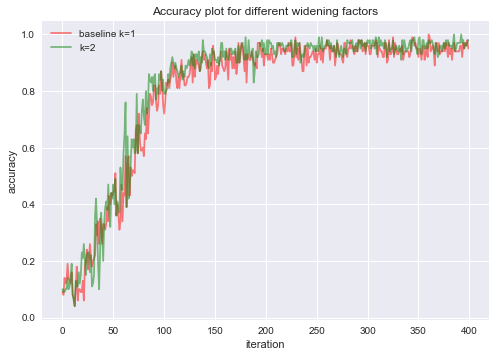

In [23]:
plt.title('Accuracy plot for different widening factors')
cols = ['r', 'g', 'b' ]
factors = ['baseline k=1', 'k=2', \
              'k=3']

for i, current in enumerate(stats):
    if i < 2:
        plt.plot(current, c=cols[i], label = factors[i], alpha=0.5)

#         plt.plot(test_accs[399], c='blue', label = factors[i], alpha=0.5)

plt.legend()
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

In [19]:
test_losses.keys()

dict_keys([399, 0, 1])

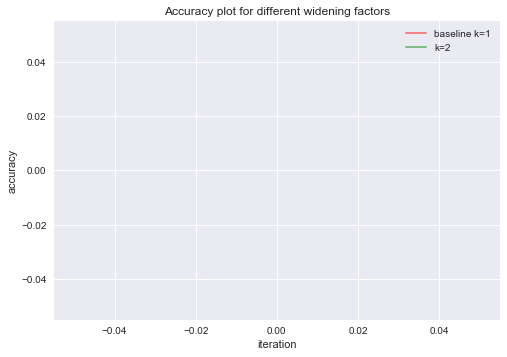

In [13]:
plt.title('Accuracy plot for different widening factors')
cols = ['r', 'g', 'b' ]
factors = ['baseline k=1', 'k=2', \
              'k=3']

for i, current in enumerate(stats):
    if i < 3:
        plt.plot(test_losses[i], c=cols[i], label = factors[i], alpha=0.5)
    
plt.legend()
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

In [33]:
f_stats = open('init_stats.txt', 'w')
f_loss = open('init_loss.txt', 'w')
pipelines = []

for wid_factor in widening_factors:
    config = {'resnet':{'conv_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                        'dense_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                        'factor':wid_factor}}
    stats = []
    loss_history = []

    ppl = (train_dataset.pipeline(config=config).
       train_res(loss_history, stats, src[0][:58500], full_labs[:58500]))
    
    ppl_test = test_dataset.pipeline(config=config)
    print('current config', config)
    for i in tqdm(range(n_iterations)):
        ppl.next_batch(100, n_epochs=None, shuffle=2)
    pipelines.append(ppl)
    
    f_stats.write('\t'.join(map(str, stats)))
    f_stats.write('\n')
    
    f_loss.write('\t'.join(map(str, loss_history)))
    f_loss.write('\n')

current config {'resnet': {'conv_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x000002091DB7E6A8>, 'dense_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x000002091DAD41E0>, 'factor': 1}}


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.39it/s]


current config {'resnet': {'conv_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x000002091E5B6E18>, 'dense_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x000002091E5B6F28>, 'factor': 2}}


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [04:06<00:00,  1.63it/s]


current config {'resnet': {'conv_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x000002091E59D0D0>, 'dense_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x000002091E58E6A8>, 'factor': 3}}


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [07:44<00:00,  1.16s/it]


current config {'resnet': {'conv_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x000002091E579378>, 'dense_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x000002091E525598>, 'factor': 4}}


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [13:46<00:00,  2.06s/it]


current config {'resnet': {'conv_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x000002091E58ED90>, 'dense_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x000002091E4EF048>, 'factor': 5}}


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [20:35<00:00,  3.16s/it]


current config {'resnet': {'conv_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x000002091E525EA0>, 'dense_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x000002091E4DB9D8>, 'factor': 6}}


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [30:07<00:00,  4.47s/it]


current config {'resnet': {'conv_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x000002091E4EF598>, 'dense_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x000002091DA7E950>, 'factor': 7}}


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [40:17<00:00,  5.95s/it]


current config {'resnet': {'conv_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x000002091E4DB048>, 'dense_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x0000020917E51510>, 'factor': 8}}


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [53:42<00:00,  8.14s/it]


current config {'resnet': {'conv_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x000002091D8BFC80>, 'dense_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x000002091D7E4620>, 'factor': 9}}


100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [1:05:59<00:00,  9.70s/it]


In [40]:
len(stats)

9

In [34]:
f_loss.close()
f_stats.close()

with open('init_stats.txt', 'r') as f_1:
    stats = []
    for i in f_1.read().splitlines():
        stats.append(i.split('\t'))

with open('init_loss.txt', 'r') as f_2:
    loss_history = []
    for i in f_2.read().splitlines():
        loss_history.append(i.split('\t'))

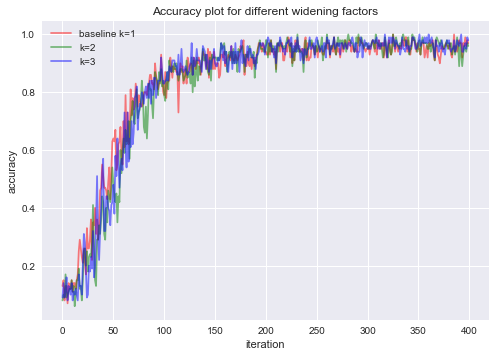

In [36]:
plt.title('Accuracy plot for different widening factors')
cols = ['r', 'g', 'b' ]
factors = ['baseline k=1', 'k=2', \
              'k=3']

for i, current in enumerate(stats):
    if i < 3:
        plt.plot(current, c=cols[i], label = factors[i], alpha=0.5)
    
plt.legend()
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

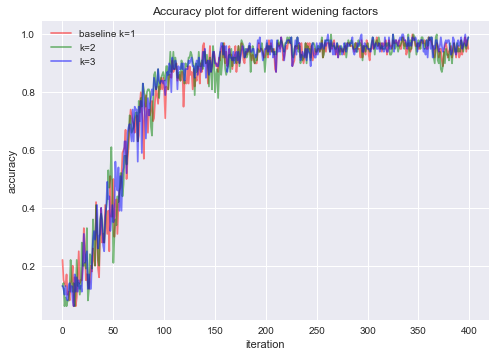

In [43]:
plt.title('Accuracy plot for different widening factors')
cols = ['r', 'g', 'b' ]
factors = ['baseline k=1', 'k=2', \
              'k=3']

for i, current in enumerate(stats):
    if i >= 3 and i < 6:
        plt.plot(current, c=cols[i%3],  label = factors[i%3], alpha=0.5)
    
plt.legend()
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

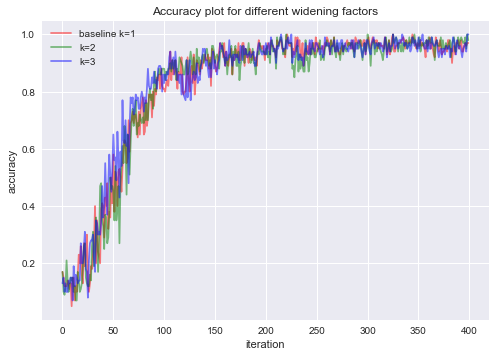

In [44]:
plt.title('Accuracy plot for different widening factors')
cols = ['r', 'g', 'b' ]
factors = ['baseline k=1', 'k=2', \
              'k=3']

for i, current in enumerate(stats):
    if i >= 6:
        plt.plot(current, c=cols[i%3],  label = factors[i%3], alpha=0.5)
    
plt.legend()
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

IndexError: list index out of range

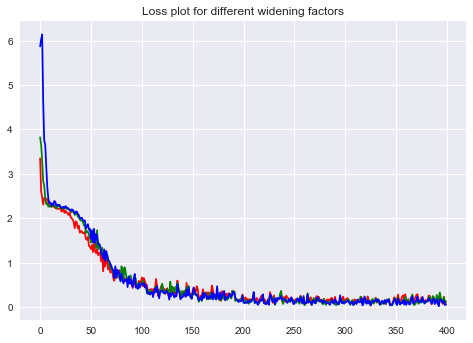

In [48]:
plt.title('Loss plot for different widening factors')
cols = ['r', 'g', 'b', 'y', 'gold', 'darkgreen']
for i, current in enumerate(loss_history):
    if i < 6:
        plt.plot(loss_history[i],c=cols[i%6], label=factors[i%6])
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.show()

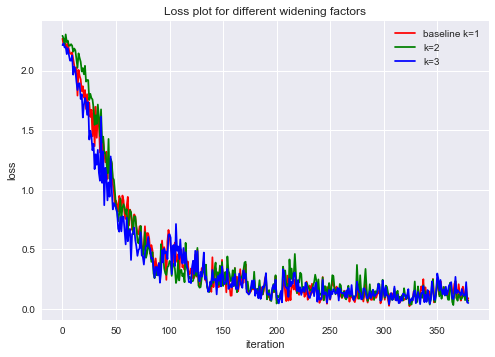

In [50]:
plt.title('Loss plot for different widening factors')
cols = ['r', 'g', 'b', 'y', 'gold', 'darkgreen']
for i, current in enumerate(loss_history):
    if i >= 6:
        plt.plot(loss_history[i][20:],c=cols[i%6], label=factors[i%6])
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.show()

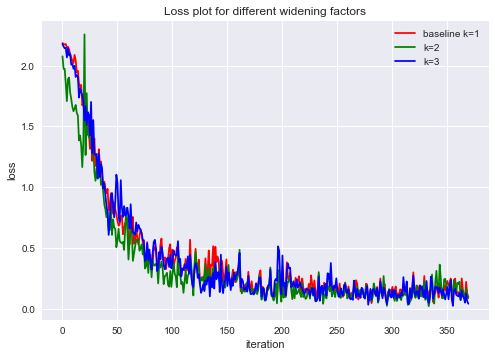

In [25]:
plt.title('Loss plot for different widening factors')
cols = ['r', 'g', 'b']
for i, current in enumerate(loss_history):
    plt.plot(loss_history[i][30:],c=cols[i], label=factors[i])
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.show()

In [54]:
test_losses = defaultdict(list)
test_accs = defaultdict(list)

In [56]:
pipelines

In [61]:
for i, ppl_i in enumerate(pipelines):
    current_loss = []
    current_acc = []
    test_ppl = (test_dataset.p.import_model('resnet', ppl_i).update_stats(current_loss, current_acc, src[0][58500:], full_labs[58500:]))
    for i in tqdm(range(100)):
        test_ppl.next_batch(100, n_epochs=None, shuffle=2)
    print ('done ', i)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]


ValueError: There is no such method 'convy'